## Weather Classification
### Model Training

In [82]:
# The usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PMML Pipeline(s)
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml.preprocessing import LookupTransformer
from sklearn2pmml.preprocessing import DaysSinceYearTransformer
from sklearn2pmml.preprocessing import PMMLLabelEncoder
from sklearn2pmml.decoration import ContinuousDomain
from sklearn2pmml.decoration import CategoricalDomain
from sklearn2pmml.decoration import DateTimeDomain
from sklearn2pmml.feature_extraction.text import Splitter

# Data Mapping
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

# Classification Models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import VotingClassifier


# Model Accuracy
from sklearn.metrics import accuracy_score

# Features Importance
from sklearn.inspection import permutation_importance

# Model Selection
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [83]:
# Dsplay pipelines
from sklearn import set_config
set_config(display="diagram")

In [84]:
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [85]:
from sklearn.model_selection import train_test_split

# Newspaper churn dataset
# It contains 15.855 records and 19 columns including the target variable Subscriber (YES/NO).
# The majority of the features is categorial.
df = pd.read_csv('../../../data/weather-classification-clean.csv')

X = df.drop('target', axis=1)
y = df['target']

In [86]:
# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [88]:
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [30]:
# Selecting categorical, numeric, datatime, and text features
numeric_features = ['MinTemp','MaxTemp','Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Cloud9am','Cloud3pm']
categorical_features = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
datetime_features = ['Date']
text_features = []
drop_features = ['Pressure3pm', 'Temp3pm', 'Temp9am']

In [31]:
mapper = DataFrameMapper(
    [([col_num], [ContinuousDomain(), SimpleImputer(strategy='median'), StandardScaler()]) for col_num in numeric_features] +
    [([col_cat], [CategoricalDomain(), SimpleImputer(strategy='most_frequent'), PMMLLabelEncoder(), StandardScaler()]) for col_cat in categorical_features] +
    [([col_dat], [DateTimeDomain(), DaysSinceYearTransformer(year = 1968), StandardScaler()]) for col_dat in datetime_features] +
    [(col_txt,   [CategoricalDomain(), CountVectorizer(tokenizer=Splitter(), max_features=5)]) for col_txt in text_features],
    drop_cols=drop_features,
    input_df=True,
    df_out=True
)

In [40]:
X_trans = mapper.fit_transform(X_test)
X_trans

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,Date
27725,-0.428930,-0.552721,-0.366698,-0.757660,0.261934,-0.525300,0.257714,-0.276800,0.179638,-0.742273,0.175874,-0.631583,1.363447,1.288710,-0.025189,-0.508620,-0.774529
19373,-1.633976,-0.887658,-0.366698,-1.625057,-1.529247,-1.805457,1.576777,-0.080028,0.002095,0.179589,0.175874,1.546667,1.363447,0.849632,-0.025189,-0.508620,-1.539903
5030,-1.289677,-0.602961,-0.366698,-1.388494,-0.812775,-1.223568,0.315065,0.165937,1.632263,0.179589,0.175874,-0.320405,1.575370,0.849632,-0.891479,-0.508620,0.861248
16953,0.500676,-0.435493,6.462669,-0.047971,1.336643,-0.059789,0.831220,1.740111,0.034375,-0.281342,1.167883,1.235488,-1.391551,-1.784832,-1.108052,1.966106,-1.051628
10946,0.156378,-0.418746,-0.366698,-0.599952,0.023110,0.289345,-0.602544,0.313515,1.261036,-1.664136,0.175874,0.301952,0.091909,1.508248,0.191384,-0.508620,1.695897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15537,1.447498,1.105218,-0.366698,-0.599952,0.500758,0.754856,0.888571,0.854638,-1.660354,0.179589,0.175874,0.924309,-0.755782,-0.687138,-0.674907,-0.508620,0.712643
24530,0.466246,0.066913,-0.366698,0.425154,0.261934,-0.758056,-2.208360,-1.506623,-1.208426,0.179589,0.175874,-1.253941,1.575370,0.410555,-1.541197,-0.508620,1.434441
4786,-1.306892,-0.134049,-0.366698,-0.757660,-1.290423,-0.758056,0.200364,-0.867115,1.890507,0.179589,0.175874,-0.320405,-1.603474,-0.028522,-0.674907,-0.508620,0.575211
3772,-0.738799,-0.904404,-0.366698,-0.915369,-0.454538,-0.292545,0.773869,0.608673,0.792968,0.179589,0.175874,-0.320405,-1.179628,1.508248,-1.541197,-0.508620,-0.676204


## Ensemble of models

In [53]:
# Ensemble of models
estimator = []
estimator.append(('svm', SVC(probability=True)))
estimator.append(('lrc', LogisticRegression(max_iter=400)))
estimator.append(('knc', KNeighborsClassifier()))
estimator.append(('rfc', RandomForestClassifier()))
estimator.append(('dtc', DecisionTreeClassifier()))

In [54]:
ppl_ensemble = PMMLPipeline([
    ("mapper", mapper),
    ('ensemble', VotingClassifier(estimators = estimator, voting ='soft'))
])

In [55]:
display(ppl_ensemble)

PMMLPipeline(steps=[('mapper', DataFrameMapper(df_out=True, drop_cols=['Pressure3pm', 'Temp3pm', 'Temp9am'],
                features=[(['MinTemp'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['MaxTemp'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['Rainfall'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['WindGus...
                            PMMLLabelEncoder(), StandardScaler()]),
                          (['WindDir3pm'],
                           [CategoricalDomain(),
                            SimpleImputer(strategy='most_frequent'),
                            PMMLLabelEncoder(), StandardScaler()]),
                          (['RainToday'],
                           [CategoricalDomain(),
                            SimpleImputer(strategy='most_frequent'),
                            PMMLLabelEncoder(), StandardScaler()]),
                          (['Date'],
                           [DateTimeDomain(),
                            DaysSinceYearTransformer(year=1968),
                            StandardScaler()])],
                input_df=True)),
       ('ensemble', VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('lrc',
                              LogisticRegression(max_iter=400,
                                                 multi_class='multinomial')),
                             ('knc', KNeighborsClassifier()),
                             ('rfc', RandomForestClassifier()),
                             ('dtc', DecisionTreeClassifier())],
                 voting='soft'))])

## Hyper-parameter Tuning

In [56]:
ppl_ensemble.get_params()

{'apply_transformer': None,
 'header': None,
 'memory': None,
 'predict_proba_transformer': None,
 'predict_transformer': None,
 'steps': [('mapper',
   DataFrameMapper(df_out=True, drop_cols=['Pressure3pm', 'Temp3pm', 'Temp9am'],
                   features=[(['MinTemp'],
                              [ContinuousDomain(),
                               SimpleImputer(strategy='median'),
                               StandardScaler()]),
                             (['MaxTemp'],
                              [ContinuousDomain(),
                               SimpleImputer(strategy='median'),
                               StandardScaler()]),
                             (['Rainfall'],
                              [ContinuousDomain(),
                               SimpleImputer(strategy='median'),
                               StandardScaler()]),
                             (['WindGus...
                               PMMLLabelEncoder(), StandardScaler()]),
                        

In [57]:
# Hyper-parameter
hyper_params = {
    'ensemble__svm__C' : [1,2],
    'ensemble__lrc__solver': ['lbfgs','newton-cg'],
    'ensemble__knc__n_neighbors' : [5,8],
    'ensemble__rfc__max_depth': [7,10],
    'ensemble__dtc__max_depth': [7,10]
}

cv_rsf = RepeatedStratifiedKFold(n_splits=2, n_repeats=1)
searcher = RandomizedSearchCV(ppl_ensemble, param_distributions=hyper_params, scoring='roc_auc', verbose=2, cv=cv_rsf)

In [58]:
# Perform model training and hyper-parmeter tuning
searcher.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END ensemble__dtc__max_depth=7, ensemble__knc__n_neighbors=5, ensemble__lrc__solver=lbfgs, ensemble__rfc__max_depth=10, ensemble__svm__C=2; total time=  19.9s
[CV] END ensemble__dtc__max_depth=7, ensemble__knc__n_neighbors=5, ensemble__lrc__solver=lbfgs, ensemble__rfc__max_depth=10, ensemble__svm__C=2; total time=  19.3s
[CV] END ensemble__dtc__max_depth=10, ensemble__knc__n_neighbors=5, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=10, ensemble__svm__C=2; total time=  20.5s
[CV] END ensemble__dtc__max_depth=10, ensemble__knc__n_neighbors=5, ensemble__lrc__solver=newton-cg, ensemble__rfc__max_depth=10, ensemble__svm__C=2; total time=  19.8s
[CV] END ensemble__dtc__max_depth=7, ensemble__knc__n_neighbors=8, ensemble__lrc__solver=lbfgs, ensemble__rfc__max_depth=10, ensemble__svm__C=2; total time=  19.9s
[CV] END ensemble__dtc__max_depth=7, ensemble__knc__n_neighbors=8, ensemble__lrc__solver=lbfgs, ensemble__rfc

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=2, random_state=None),
                   estimator=PMMLPipeline(steps=[('mapper', DataFrameMapper(df_out=True, drop_cols=['Pressure3pm', 'Temp3pm', 'Temp9am'], features=[(['MinTemp'], [ContinuousDomain(), SimpleImputer(strategy='median'), StandardScaler()]), (['MaxTemp'], [ContinuousDomain(), SimpleImputer(strate...nomial')), ('knc', KNeighborsClassifier()), ('rfc', RandomForestClassifier()), ('dtc', DecisionTreeClassifier())], voting='soft'))]),
                   param_distributions={'ensemble__dtc__max_depth': [7, 10],
                                        'ensemble__knc__n_neighbors': [5, 8],
                                        'ensemble__lrc__solver': ['lbfgs',
                                                                  'newton-cg'],
                                        'ensemble__rfc__max_depth': [7, 10],
                                        'ensemble__svm__C': [1, 2]},
                   scoring='roc_auc', verbose=2)

In [66]:
# Select best model
best_pipeline = searcher.best_estimator_
best_params = searcher.best_params_
best_pipeline.verify(X_train.sample(n = 10))

In [67]:
display(best_pipeline)

PMMLPipeline(steps=[('mapper', DataFrameMapper(df_out=True, drop_cols=['Pressure3pm', 'Temp3pm', 'Temp9am'],
                features=[(['MinTemp'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['MaxTemp'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['Rainfall'],
                           [ContinuousDomain(),
                            SimpleImputer(strategy='median'),
                            StandardScaler()]),
                          (['WindGus...
                            PMMLLabelEncoder(), StandardScaler()]),
                          (['WindDir3pm'],
                           [CategoricalDomain(),
                            SimpleImputer(strategy='most_frequent'),
                            PMMLLabelEncoder(), StandardScaler()]),
                          (['RainToday'],
                           [CategoricalDomain(),
                            SimpleImputer(strategy='most_frequent'),
                            PMMLLabelEncoder(), StandardScaler()]),
                          (['Date'],
                           [DateTimeDomain(),
                            DaysSinceYearTransformer(year=1968),
                            StandardScaler()])],
                input_df=True)),
       ('ensemble', VotingClassifier(estimators=[('svm', SVC(C=2, probability=True)),
                             ('lrc',
                              LogisticRegression(max_iter=400,
                                                 multi_class='multinomial')),
                             ('knc', KNeighborsClassifier()),
                             ('rfc', RandomForestClassifier(max_depth=10)),
                             ('dtc', DecisionTreeClassifier(max_depth=7))],
                 voting='soft'))])

In [68]:
best_params

{'ensemble__svm__C': 2,
 'ensemble__rfc__max_depth': 10,
 'ensemble__lrc__solver': 'lbfgs',
 'ensemble__knc__n_neighbors': 5,
 'ensemble__dtc__max_depth': 7}

In [69]:
y_pred = best_pipeline.predict(X_test)

In [70]:
# using accuracy_score
from sklearn.metrics import f1_score

print(f'The model accuracy is: {np.round(accuracy_score(y_test, y_pred), decimals=3)*100}%')
print(f'The model f1 score is: {np.round(f1_score(y_test, y_pred, average="""weighted"""), decimals=3)*100}%')

The model accuracy is: 86.0%
The model f1 score is: 84.5%


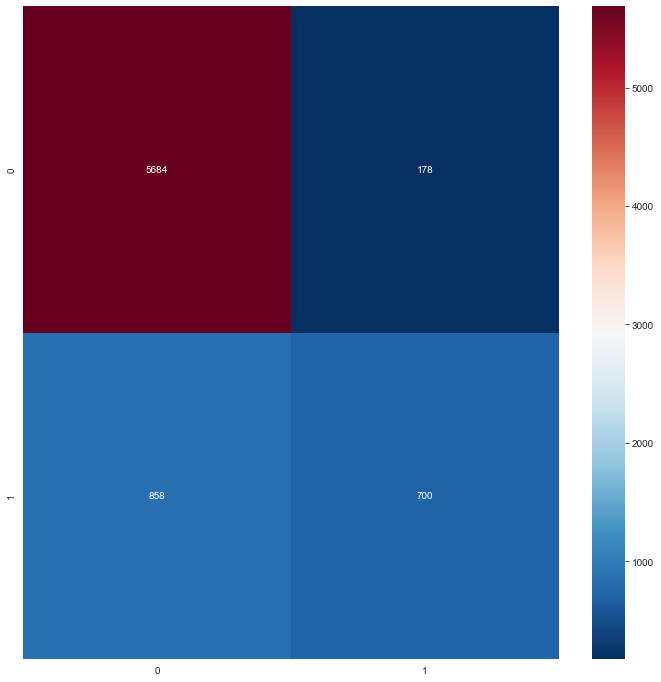

In [71]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=best_pipeline.classes_)
plt.figure(figsize=(12, 12))
cmap = sns.color_palette("Oranges",12)
sns.heatmap(data=cm, cmap="RdBu_r", xticklabels=best_pipeline.classes_, yticklabels=best_pipeline.classes_, fmt='g', annot=True)
plt.show()

<Figure size 2160x2160 with 0 Axes>

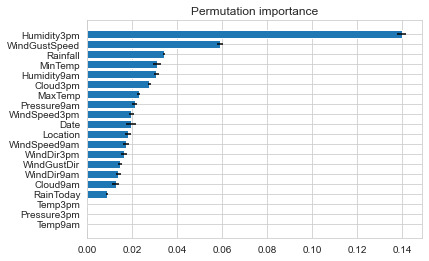

In [72]:
# https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html
def plot_feature_importances(pi_result, features_name):
    """ bar plot the feature importance """
    plt.figure(figsize=(30, 30))
    fig, ax = plt.subplots()

    indices = pi_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             pi_result['importances_mean'][indices],
             xerr=pi_result['importances_std'][indices])

    ax.set_yticks(range(len(indices)))
    tmp = np.array(features_name)
    ax.set_yticklabels(tmp[indices])
    ax.set_title("Permutation importance")

ppl_ensemble.fit(X_test,y_test)
pi_result = permutation_importance(ppl_ensemble, X_test, y_test)
plot_feature_importances(pi_result, X_test.columns)

## Save the model

In [73]:
# Save the best model in PMML format
sklearn2pmml(best_pipeline, "../../../data/weather-classification-ensemble-classifier.pmml")